<a href="https://colab.research.google.com/github/imranajec/video-processing-multimodal-index/blob/main/Video_Processing_and_MultiModal_Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!pip install llama-index-vector-stores-lancedb
!pip install llama-index-multi-modal-llms-openai
!pip install llama-index-embeddings-clip
!pip install git+https://github.com/openai/CLIP.git
!pip install llama-index-readers-file
!pip install llama_index
!pip install -U openai-whisper
!pip install lancedb
!pip install moviepy
!pip install pytube
!pip install pydub
!pip install SpeechRecognition
!pip install ffmpeg-python
!pip install soundfile
!pip install torch torchvision
!pip install matplotlib scikit-image
!pip install ftfy regex tqdm

  Using cached pillow-10.3.0-cp310-cp310-manylinux_2_28_x86_64.whl (4.5 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 10.0.1
    Uninstalling Pillow-10.0.1:
      Successfully uninstalled Pillow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.3.0 which is incompatible.


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-lllavtj7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-lllavtj7
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached Pillow-10.0.1-cp310-cp310-manylinux_2_28_x86_64.whl (3.6 MB)
ERROR: Operation cancelled by user
ERROR: Operation cancelled by user
  Using cached Pillow-10.0.1-cp310-cp310-manylinux_2_28_x86_64.whl (3.6 MB)
  Attempting uninstall: pillow
    Found existing installation: pillow 10.3.0
    Uninstalling pillow-10.3.0:
      Successfully uninstalled pillow-10.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llama-index-embeddings-clip 0.1.5 requires pillow<11.0.0,>=10.2.0, but you have pillow 10.0.1 which is incompatible.

In [50]:
from moviepy.editor import VideoFileClip
from pytube import YouTube
import os
import speech_recognition as sr
from pathlib import Path


In [51]:
import os
from google.colab import userdata
OPENAI_API_TOKEN=userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN


In [52]:
video_url = "https://www.youtube.com/watch?v=uoYSNvHr2OM"
output_video_path = "/content/drive/MyDrive/Video processing/Video Data"
output_folder = "/content/drive/MyDrive/Video processing"
output_audio_path = "/content/drive/MyDrive/Video processingoutput_audio.wav"

In [53]:
os.makedirs(output_folder, exist_ok=True)

In [54]:
# Function to download the video
def download_video(url, output_path):
    yt = YouTube(url)
    metadata = {"Author": yt.author, "Title": yt.title, "Views": yt.views}
    yt.streams.get_highest_resolution().download(output_path=output_path, filename="input_vid.mp4")
    return metadata

In [55]:
# Function to convert video to images
def video_to_images(video_path, output_folder):
    clip = VideoFileClip(video_path)
    clip.write_images_sequence(os.path.join(output_folder, "frame%04d.png"), fps=1)


In [56]:
# Function to extract audio from video
def video_to_audio(video_path, output_audio_path):
    clip = VideoFileClip(video_path)
    audio = clip.audio
    audio.write_audiofile(output_audio_path)

In [57]:
# Function to convert audio to text
def audio_to_text(audio_path):
    recognizer = sr.Recognizer()
    audio = sr.AudioFile(audio_path)
    with audio as source:
        audio_data = recognizer.record(source)
        try:
            text = recognizer.recognize_whisper(audio_data)
        except sr.UnknownValueError:
            print("Speech recognition could not understand the audio.")
    return text

In [58]:
# Download the video
metadata_vid = download_video(video_url, output_video_path)
video_path = os.path.join(output_video_path, "input_vid.mp4")

In [59]:
# Convert video to images
video_to_images(video_path, output_folder)

Moviepy - Writing frames /content/drive/MyDrive/Video processing/frame%04d.png.


Moviepy - Done writing frames /content/drive/MyDrive/Video processing/frame%04d.png.


In [60]:
# Extract audio from video
video_to_audio(video_path, output_audio_path)

MoviePy - Writing audio in /content/drive/MyDrive/Video processingoutput_audio.wav


MoviePy - Done.


In [61]:
# Convert audio to text
text_data = audio_to_text(output_audio_path)
with open(os.path.join(output_folder, "output_text.txt"), "w") as file:
    file.write(text_data)

In [62]:
# Step 3: Build Multi-Modal Index and Vector Store
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import SimpleDirectoryReader
from llama_index.core import StorageContext
from llama_index.vector_stores.lancedb import LanceDBVectorStore


In [63]:
text_store = LanceDBVectorStore(uri="lancedb", table_name="text_collection")
image_store = LanceDBVectorStore(uri="lancedb", table_name="image_collection")
storage_context = StorageContext.from_defaults(vector_store=text_store, image_store=image_store)


In [64]:
documents = SimpleDirectoryReader(output_folder).load_data()
index = MultiModalVectorStoreIndex.from_documents(documents, storage_context=storage_context)


In [65]:
retriever_engine = index.as_retriever(similarity_top_k=5, image_similarity_top_k=5)

In [66]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode


In [67]:
def retrieve(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)
    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)
    return retrieved_image, retrieved_text


**Node ID:** 82d5fa4f-6d6a-492f-999e-319298e3a138<br>**Similarity:** 0.6588214635848999<br>**Text:** There are some exciting news from Google, but there's also a bit of controversy to unpack. So let's just get started. Google just announced a massive update with their video generation model called...<br>

**Node ID:** c44506eb-30f9-4302-90f4-7d992181c355<br>**Similarity:** 0.5717361569404602<br>**Text:** This stands for diversity, equity, and inclusion. When you select this mode, GROC will be described as the senior vice president of DE and I, okay? Even the GROC icon gets a makeover and becomes mo...<br>

**Node ID:** 88fb2785-1e4c-4ac0-8fc9-c5512ef540b7<br>**Similarity:** 0.5309015512466431<br>**Text:** I have to tell you about this super cool invention from researchers at Cambridge University, a robotic third thumb. And it's not some weird extra finger made of flesh, it's a mechanical digit that'...<br>

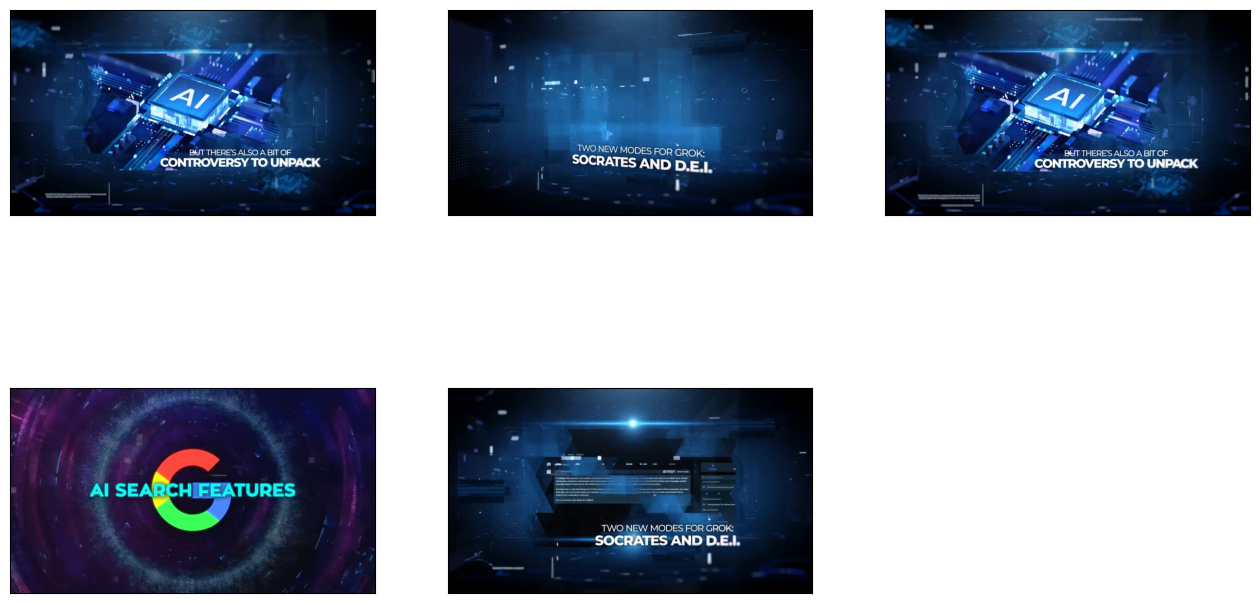

In [68]:
# Step 5: Augment the prompt
import matplotlib.pyplot as plt
from PIL import Image

def plot_images(images_path):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in images_path:
        if os.path.isfile(img_path):
            image = Image.open(img_path)
            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            images_shown += 1
            if images_shown >= 5:
                break

query = "what are the updates on google veo ai"
img, text = retrieve(retriever_engine, query)

# Plot retrieved images
plot_images(img)


In [69]:
import textwrap

text_string = " ".join(text)  # Join the list into a single string
wrapped_text = textwrap.fill(text_string, width=100)  # Adjust the width as needed
print(wrapped_text)


There are some exciting news from Google, but there's also a bit of controversy to unpack. So let's
just get started. Google just announced a massive update with their video generation model called
Vio. This model is part of their DeepMind project and now it can create video clips from a single
reference image. Essentially, you give it a picture and some text instructions and it can generate a
whole video clip based on that. For example, they showed off an image prompt where a woman's hands
are holding a large amethyst crystal. Her nails are painted purple and she has a gold ring on her
pinky finger. The new model took that and generated a video clip that looks just like the original
style but animated. As you can see, there's no loss in quality, no glitches or anything like that.
It's incredibly realistic, maybe even a bit too realistic. Another example was an elderly woman
wearing a straw hat and a pink jacket sitting next to a brown and white dog. Both are looking off
into the dista

In [70]:
qa_tmpl_str = (
    "Based on the provided information, including relevant images and retrieved context from the video, "
    "accurately and precisely answer the query without any additional prior knowledge.\n"
    "---------------------\n"
    "Context: {context_str}\n"
    "Metadata for video: {metadata_str} \n"
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

In [71]:
import json
metadata_str = json.dumps(metadata_vid)
context_str = "".join(text)



In [72]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

openai_mm_llm = OpenAIMultiModal(model="gpt-4-vision-preview", api_key=os.getenv("OPENAI_API_KEY"), max_new_tokens=1500)
image_documents = SimpleDirectoryReader(input_files=img).load_data()

result = openai_mm_llm.complete(
    prompt=qa_tmpl_str.format(
        query_str=query_str, context_str=context_str, metadata_str=metadata_str
    ),
    image_documents=image_documents,
)

In [73]:
from pprint import pprint
pprint(result.text)


('Google has announced a significant update to their video generation model '
 'called Vio, which is part of their DeepMind project. The updated Vio model '
 'can now create video clips from a single reference image. Users can provide '
 'a picture along with text instructions, and Vio will generate a video clip '
 'that maintains the original style and appears animated. The update was '
 'demonstrated with examples, such as a video clip generated from an image of '
 'a woman holding an amethyst crystal and another of an elderly woman with a '
 "dog, both showcasing the model's ability to capture the essence and details "
 'from just a single image.\n'
 '\n'
 'Additionally, Google introduced the VideoFX Update, which allows developers '
 'to create full HD videos from text prompts using Vio. This tool has the '
 'potential to change the way artists, content creators, and developers '
 'produce video content.\n'
 '\n'
 'Google has also introduced a new Gemini AI button in the side panel